In [1]:
%matplotlib inline

In [2]:
import os
import time
import glob
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import tensorflow_addons as tfa

from skimage import measure
from skimage.io import imread, imsave, imshow
from skimage.transform import resize
from skimage.filters import gaussian
from skimage.morphology import dilation, disk
from skimage.draw import polygon, polygon_perimeter

print(f'Tensorflow version {tf.__version__}')
print(f'GPU is {"ON" if tf.config.list_physical_devices("GPU") else "OFF" }')

Tensorflow version 2.9.1
GPU is ON


In [3]:
gpus = tf.config.list_physical_devices('GPU')
if gpus:
  try:
    tf.config.set_logical_device_configuration(
        gpus[0],
        [tf.config.LogicalDeviceConfiguration(memory_limit=int(1024*2.5))])
    logical_gpus = tf.config.list_logical_devices('GPU')
    print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPUs")
  except RuntimeError as e:
    # Virtual devices must be set before GPUs have been initialized
    print(e)

1 Physical GPUs, 1 Logical GPUs


In [4]:
CLASSES = 3

COLORS = ['black', 'red', 'lime']

SAMPLE_SIZE = (256, 256)

OUTPUT_SIZE = (256, 256)

In [5]:
def load_images(image, mask):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0
    
    print(image)
    
    mask = tf.io.read_file(mask)
    mask = tf.io.decode_png(mask)
    #mask = tf.image.rgb_to_grayscale(mask)
    mask = tf.image.resize(mask, OUTPUT_SIZE)
    mask = tf.image.convert_image_dtype(mask, tf.float32)
    
    print(mask)
    
    masks = []
    
    for i in range(CLASSES):
        masks.append(tf.where(tf.equal(mask, float(i)), 1.0, 0.0))
        print(mask)
    
    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))
    
    print(masks)
    
    return image, masks

def augmentate_images(image, masks):   
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)
    
    random_flip = tf.random.uniform((), 0, 1)    
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    
    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)
    
    return image, masks

In [6]:
def load_images_2(image, mask_bg, mask_car, mask_th):
    image = tf.io.read_file(image)
    image = tf.io.decode_jpeg(image)
    image = tf.image.resize(image, OUTPUT_SIZE)
    image = tf.image.convert_image_dtype(image, tf.float32)
    image = image / 255.0
    
    print(image)
    
    mask_bg = tf.io.read_file(mask_bg)
    mask_bg = tf.io.decode_png(mask_bg)
    mask_bg = tf.image.resize(mask_bg, OUTPUT_SIZE)
    mask_bg = tf.image.convert_image_dtype(mask_bg, tf.float32)
    
    mask_car = tf.io.read_file(mask_car)
    mask_car = tf.io.decode_png(mask_car)
    mask_car = tf.image.resize(mask_car, OUTPUT_SIZE)
    mask_car = tf.image.convert_image_dtype(mask_car, tf.float32)
    
    mask_th = tf.io.read_file(mask_th)
    mask_th = tf.io.decode_png(mask_th)
    mask_th = tf.image.resize(mask_th, OUTPUT_SIZE)
    mask_th = tf.image.convert_image_dtype(mask_th, tf.float32)
    
    
    masks = []
        
    masks.append(mask_bg)
    masks.append(mask_th)
    masks.append(mask_car)
    
    masks = tf.stack(masks, axis=2)
    masks = tf.reshape(masks, OUTPUT_SIZE + (CLASSES,))
    
    print(masks)
    
    return image, masks

def augmentate_images(image, masks):   
    random_crop = tf.random.uniform((), 0.3, 1)
    image = tf.image.central_crop(image, random_crop)
    masks = tf.image.central_crop(masks, random_crop)
    
    random_flip = tf.random.uniform((), 0, 1)    
    if random_flip >= 0.5:
        image = tf.image.flip_left_right(image)
        masks = tf.image.flip_left_right(masks)
    
    image = tf.image.resize(image, SAMPLE_SIZE)
    masks = tf.image.resize(masks, SAMPLE_SIZE)
    
    return image, masks

In [7]:
masks_bg = sorted(glob.glob('C:/Users/HAXF13D/Desktop/data/masks/background/*.png'))
masks_car = sorted(glob.glob('C:/Users/HAXF13D/Desktop/data/masks/caries/*.png'))
masks_th = sorted(glob.glob('C:/Users/HAXF13D/Desktop/data/masks/teeth/*.png'))
images = sorted(glob.glob('C:/Users/HAXF13D/Desktop/data/all/*.jpg'))

In [8]:
images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_bg_dataset = tf.data.Dataset.from_tensor_slices(masks_bg)
masks_car_dataset = tf.data.Dataset.from_tensor_slices(masks_car)
masks_th_dataset = tf.data.Dataset.from_tensor_slices(masks_th)

dataset = tf.data.Dataset.zip((images_dataset, masks_bg_dataset, masks_car_dataset, masks_th_dataset))

dataset = dataset.map(load_images_2, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.repeat(50)
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE)
print(len(dataset))

Tensor("truediv:0", shape=(256, 256, None), dtype=float32)
Tensor("Reshape:0", shape=(256, 256, 3), dtype=float32)
42650


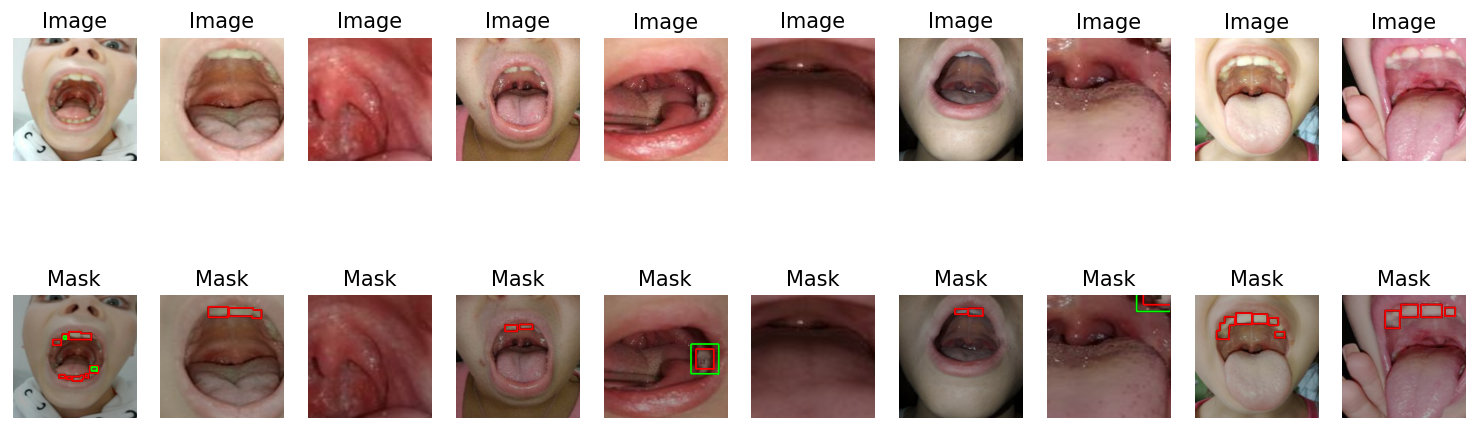

In [9]:
images_and_masks = list(dataset.skip(40000).take(10))

fig, ax = plt.subplots(nrows = 2, ncols = 10, figsize=(15, 5), dpi=125)

for i, (image, masks) in enumerate(images_and_masks):
    ax[0, i].set_title('Image')
    ax[0, i].set_axis_off()
    ax[0, i].imshow(image)
        
    ax[1, i].set_title('Mask')
    ax[1, i].set_axis_off()    
    ax[1, i].imshow(image/1.5)
   
    for channel in range(CLASSES):
        contours = measure.find_contours(np.array(masks[:,:,channel]))
        for contour in contours:
            ax[1, i].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])

plt.show()
plt.close()

In [10]:
train_dataset = dataset.take(29855).cache()
test_dataset = dataset.skip(29855).take(12795).cache()
print(len(train_dataset))
print(len(test_dataset))
train_dataset = train_dataset.batch(8)
test_dataset = test_dataset.batch(8)

29855
12795


In [11]:
def input_layer():
    return tf.keras.layers.Input(shape=SAMPLE_SIZE + (3,))

def downsample_block(filters, size, batch_norm=True):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
      tf.keras.layers.Conv2D(filters, size, strides=2, padding='same',
                             kernel_initializer=initializer, use_bias=False))

    if batch_norm:
        result.add(tf.keras.layers.BatchNormalization())
    
    result.add(tf.keras.layers.LeakyReLU())
    return result

def upsample_block(filters, size, dropout=False):
    initializer = tf.keras.initializers.GlorotNormal()

    result = tf.keras.Sequential()
    
    result.add(
        tf.keras.layers.Conv2DTranspose(filters, size, strides=2, padding='same',
                                        kernel_initializer=initializer, use_bias=False))

    result.add(tf.keras.layers.BatchNormalization())
    
    if dropout:
        result.add(tf.keras.layers.Dropout(0.25))
    
    result.add(tf.keras.layers.ReLU())
    return result

def output_layer(size):
    initializer = tf.keras.initializers.GlorotNormal()
    return tf.keras.layers.Conv2DTranspose(CLASSES, size, strides=2, padding='same',
                                           kernel_initializer=initializer, activation='sigmoid')

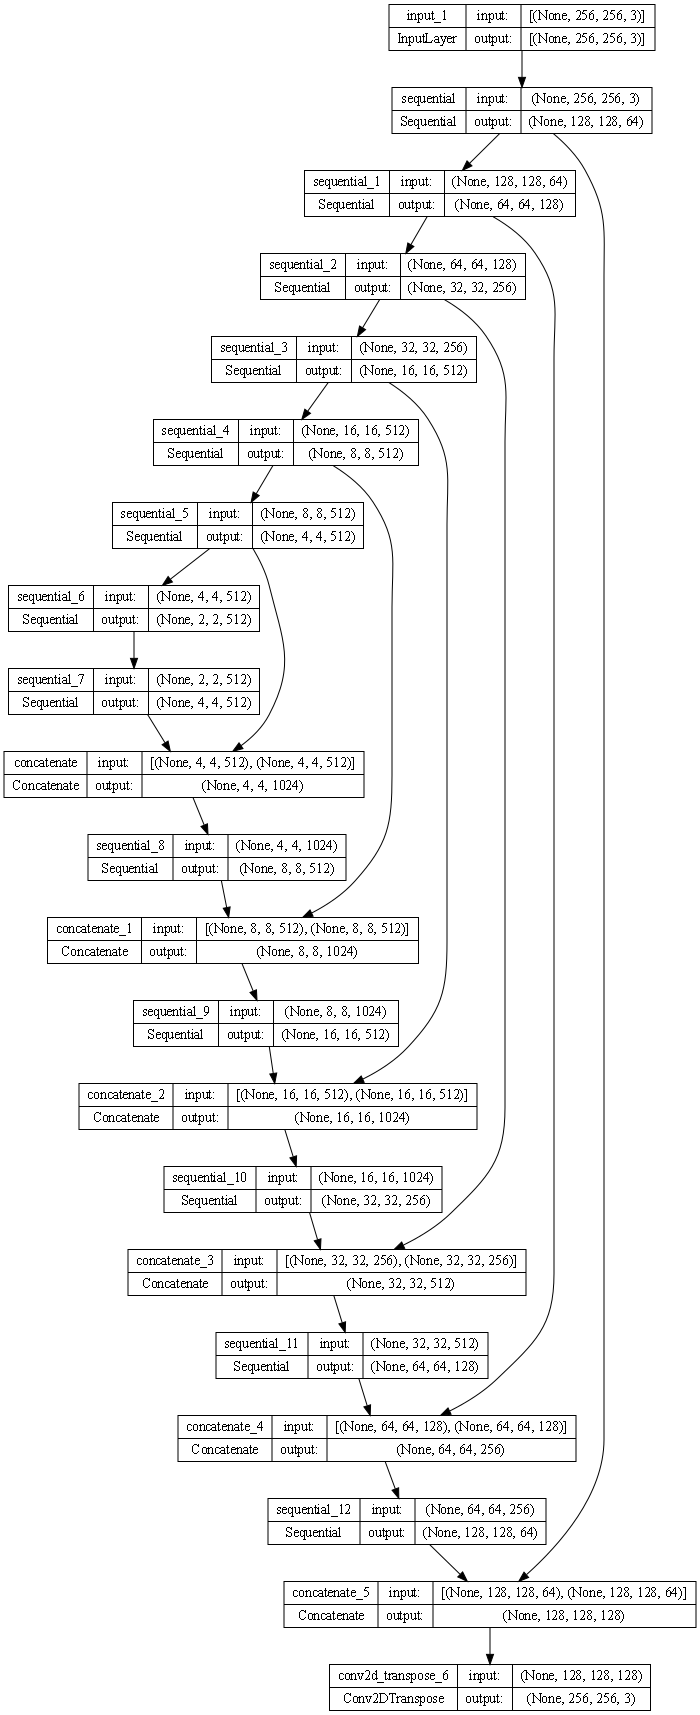

In [12]:
inp_layer = input_layer()

downsample_stack = [
    downsample_block(64, 4, batch_norm=False),
    downsample_block(128, 4),
    downsample_block(256, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
    downsample_block(512, 4),
]

upsample_stack = [
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(512, 4, dropout=True),
    upsample_block(256, 4),
    upsample_block(128, 4),
    upsample_block(64, 4)
]

out_layer = output_layer(4)

# Реализуем skip connections
x = inp_layer

downsample_skips = []

for block in downsample_stack:
    x = block(x)
    downsample_skips.append(x)
    
downsample_skips = reversed(downsample_skips[:-1])

for up_block, down_block in zip(upsample_stack, downsample_skips):
    x = up_block(x)
    x = tf.keras.layers.Concatenate()([x, down_block])

out_layer = out_layer(x)

unet_like = tf.keras.Model(inputs=inp_layer, outputs=out_layer)

tf.keras.utils.plot_model(unet_like, show_shapes=True, dpi=72)

In [13]:
def dice_mc_metric(a, b):
    a = tf.unstack(a, axis=3)
    b = tf.unstack(b, axis=3)
    
    dice_summ = 0
    
    for i, (aa, bb) in enumerate(zip(a, b)):
        numenator = 2 * tf.math.reduce_sum(aa * bb) + 1
        denomerator = tf.math.reduce_sum(aa + bb) + 1
        dice_summ += numenator / denomerator
        
    avg_dice = dice_summ / CLASSES
    
    return avg_dice

def dice_mc_loss(a, b):
    return 1 - dice_mc_metric(a, b)

def dice_bce_mc_loss(a, b):
    return 0.3 * dice_mc_loss(a, b) + tf.keras.losses.binary_crossentropy(a, b)

In [13]:
unet_like.compile(optimizer='adam', loss=[dice_bce_mc_loss], metrics=[dice_mc_metric])

In [ ]:
history_dice = unet_like.fit(train_dataset, validation_data=test_dataset, epochs=20, initial_epoch=0)

unet_like.save_weights('C:/Users/HAXF13D/Desktop/data/network/network')

Epoch 1/20
2100/3732 [===============>..............] - ETA: 13:45 - loss: 0.2062 - dice_mc_metric: 0.5623

In [43]:
unet_like.load_weights('C:/Users/HAXF13D/Desktop/data/network/network')

In [38]:
masks_bg = sorted(glob.glob('C:/Users/HAXF13D/Desktop/additional_data/masks/background/*.png'))
masks_car = sorted(glob.glob('C:/Users/HAXF13D/Desktop/additional_data/masks/caries/*.png'))
masks_th = sorted(glob.glob('C:/Users/HAXF13D/Desktop/additional_data/masks/teeth/*.png'))
images = sorted(glob.glob('C:/Users/HAXF13D/Desktop/additional_data/all/*.jpg'))

In [39]:
images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_bg_dataset = tf.data.Dataset.from_tensor_slices(masks_bg)
masks_car_dataset = tf.data.Dataset.from_tensor_slices(masks_car)
masks_th_dataset = tf.data.Dataset.from_tensor_slices(masks_th)

dataset = tf.data.Dataset.zip((images_dataset, masks_bg_dataset, masks_car_dataset, masks_th_dataset))

dataset = dataset.map(load_images_2, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.repeat(50)
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE)
print(len(dataset))

Tensor("truediv:0", shape=(256, 256, None), dtype=float32)
Tensor("Reshape:0", shape=(256, 256, 3), dtype=float32)
2300


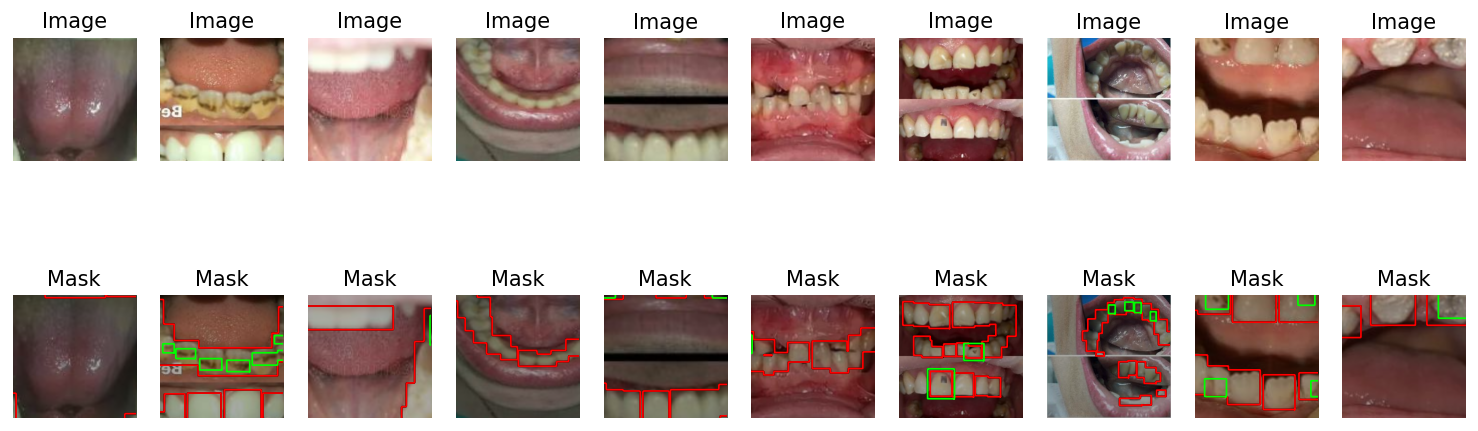

In [40]:
images_and_masks = list(dataset.skip(2000).take(10))

fig, ax = plt.subplots(nrows = 2, ncols = 10, figsize=(15, 5), dpi=125)

for i, (image, masks) in enumerate(images_and_masks):
    ax[0, i].set_title('Image')
    ax[0, i].set_axis_off()
    ax[0, i].imshow(image)
        
    ax[1, i].set_title('Mask')
    ax[1, i].set_axis_off()    
    ax[1, i].imshow(image/1.5)
   
    for channel in range(CLASSES):
        contours = measure.find_contours(np.array(masks[:,:,channel]))
        for contour in contours:
            ax[1, i].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])

plt.show()
plt.close()

In [46]:
train_dataset = dataset.take(1840).cache()
test_dataset = dataset.skip(1840).take(460).cache()
print(len(train_dataset))
print(len(test_dataset))
train_dataset = train_dataset.batch(8)
test_dataset = test_dataset.batch(8)

1840
460


In [47]:
unet_like.compile(optimizer='adam', loss=[dice_bce_mc_loss], metrics=[dice_mc_metric])

In [48]:
history_dice = unet_like.fit(train_dataset, validation_data=test_dataset, epochs=20, initial_epoch=0)
unet_like.save_weights('C:/Users/HAXF13D/Desktop/data/network_2/network')

Epoch 1/20
230/230 [==============================] - 94s 401ms/step - loss: 0.2390 - dice_mc_metric: 0.7376 - val_loss: 0.1513 - val_dice_mc_metric: 0.8131
Epoch 2/20
230/230 [==============================] - 109s 475ms/step - loss: 0.1239 - dice_mc_metric: 0.8581 - val_loss: 0.1132 - val_dice_mc_metric: 0.8684
Epoch 3/20
230/230 [==============================] - 130s 566ms/step - loss: 0.0948 - dice_mc_metric: 0.8995 - val_loss: 0.0940 - val_dice_mc_metric: 0.8985
Epoch 4/20
230/230 [==============================] - 131s 569ms/step - loss: 0.0801 - dice_mc_metric: 0.9183 - val_loss: 0.0832 - val_dice_mc_metric: 0.9130
Epoch 5/20
230/230 [==============================] - 123s 534ms/step - loss: 0.0701 - dice_mc_metric: 0.9301 - val_loss: 0.0752 - val_dice_mc_metric: 0.9226
Epoch 6/20
230/230 [==============================] - 103s 446ms/step - loss: 0.0632 - dice_mc_metric: 0.9377 - val_loss: 0.0723 - val_dice_mc_metric: 0.9283
Epoch 7/20
230/230 [==============================] -

In [49]:
unet_like.load_weights('C:/Users/HAXF13D/Desktop/data/network_2/network')

In [ ]:
import os

1/1 [==============================] - 0s 16ms/step


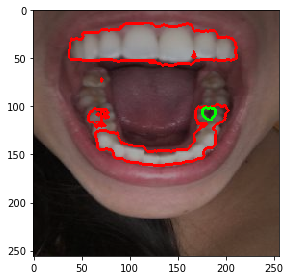

In [37]:

filepath = "C:/Users/HAXF13D/Desktop/my_test_data"
files = os.listdir(filepath)
rgb_colors = [
    (0,   0,   0),
    (255, 0,   0),
    (0,   255, 0),
    (0,   0,   255),
    (255, 165, 0),
    (255, 192, 203),
    (0,   255, 255),
    (255, 0,   255)
]

for filename in files:
    frame = imread(filename)
    sample = resize(frame, SAMPLE_SIZE)

    predict = unet_like.predict(sample.reshape((1,) +  SAMPLE_SIZE + (3,)))
    predict = predict.reshape(SAMPLE_SIZE + (CLASSES,))

    scale = frame.shape[0] / SAMPLE_SIZE[0], frame.shape[1] / SAMPLE_SIZE[1]

    frame = (frame / 1.5).astype(np.uint8)

    for channel in range(1, CLASSES): 
        contour_overlay = np.zeros((frame.shape[0], frame.shape[1]))
        contours = measure.find_contours(np.array(predict[:,:,channel]))

        try:
            for contour in contours:
                rr, cc = polygon_perimeter(contour[:, 0] * scale[0],
                                           contour[:, 1] * scale[1],
                                           shape=contour_overlay.shape)

                contour_overlay[rr, cc] = 1        

            contour_overlay = dilation(contour_overlay, disk(1))
            frame[contour_overlay == 1] = rgb_colors[channel]
        except:
            pass

    imshow(frame)

In [50]:
unet_like.load_weights('C:/Users/HAXF13D/Desktop/data/network_2/network')

In [71]:
masks_bg = sorted(glob.glob('C:/Users/HAXF13D/Desktop/addition_traning_data/masks/background/*.png'))
masks_car = sorted(glob.glob('C:/Users/HAXF13D/Desktop/addition_traning_data/masks/caries/*.png'))
masks_th = sorted(glob.glob('C:/Users/HAXF13D/Desktop/addition_traning_data/masks/teeth/*.png'))
images = sorted(glob.glob('C:/Users/HAXF13D/Desktop/addition_traning_data/all/*.jpg'))

In [76]:
images_dataset = tf.data.Dataset.from_tensor_slices(images)
masks_bg_dataset = tf.data.Dataset.from_tensor_slices(masks_bg)
masks_car_dataset = tf.data.Dataset.from_tensor_slices(masks_car)
masks_th_dataset = tf.data.Dataset.from_tensor_slices(masks_th)

dataset = tf.data.Dataset.zip((images_dataset, masks_bg_dataset, masks_car_dataset, masks_th_dataset))

dataset = dataset.map(load_images_2, num_parallel_calls=tf.data.AUTOTUNE)
dataset = dataset.repeat(60)
dataset = dataset.map(augmentate_images, num_parallel_calls=tf.data.AUTOTUNE)
print(len(dataset))

Tensor("truediv:0", shape=(256, 256, None), dtype=float32)
Tensor("Reshape:0", shape=(256, 256, 3), dtype=float32)
5040


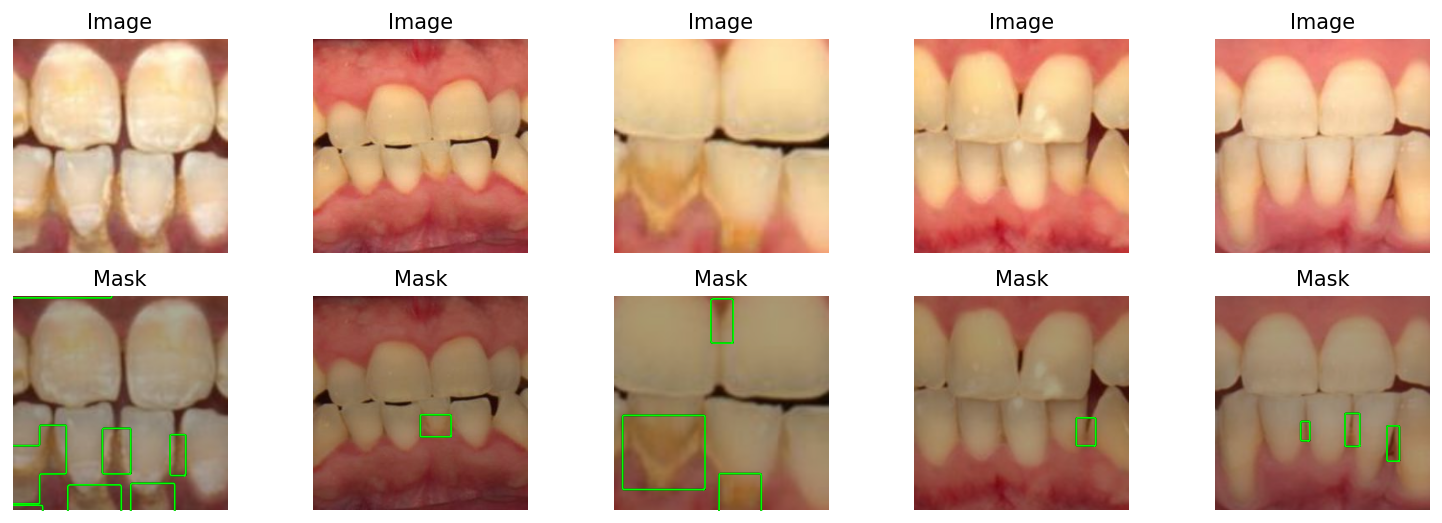

In [77]:
images_and_masks = list(dataset.skip(54).take(5))

fig, ax = plt.subplots(nrows = 2, ncols = 5, figsize=(15, 5), dpi=125)

for i, (image, masks) in enumerate(images_and_masks):
    ax[0, i].set_title('Image')
    ax[0, i].set_axis_off()
    ax[0, i].imshow(image)
        
    ax[1, i].set_title('Mask')
    ax[1, i].set_axis_off()    
    ax[1, i].imshow(image/1.5)
   
    for channel in range(CLASSES):
        contours = measure.find_contours(np.array(masks[:,:,channel]))
        for contour in contours:
            ax[1, i].plot(contour[:, 1], contour[:, 0], linewidth=1, color=COLORS[channel])

plt.show()
plt.close()

In [78]:
train_dataset = dataset.take(len(dataset) // 100 * 70).cache()
test_dataset = dataset.skip(len(dataset) // 100 * 70).take(len(dataset) - len(dataset) // 100 * 70).cache()
print(len(train_dataset))
print(len(test_dataset))
train_dataset = train_dataset.batch(8)
test_dataset = test_dataset.batch(8)

3500
1540


In [79]:
unet_like.compile(optimizer='adam', loss=[dice_bce_mc_loss], metrics=[dice_mc_metric])

In [80]:
history_dice = unet_like.fit(train_dataset, validation_data=test_dataset, epochs=20, initial_epoch=0)
unet_like.save_weights('C:/Users/HAXF13D/Desktop/data/network_3/network')

Epoch 1/20
438/438 [==============================] - 190s 429ms/step - loss: 0.4061 - dice_mc_metric: 0.6740 - val_loss: 0.2853 - val_dice_mc_metric: 0.6851
Epoch 2/20
438/438 [==============================] - 181s 414ms/step - loss: 0.1560 - dice_mc_metric: 0.8012 - val_loss: 0.1997 - val_dice_mc_metric: 0.7572
Epoch 3/20
438/438 [==============================] - 190s 435ms/step - loss: 0.1243 - dice_mc_metric: 0.8359 - val_loss: 0.1723 - val_dice_mc_metric: 0.7836
Epoch 4/20
438/438 [==============================] - 190s 435ms/step - loss: 0.1008 - dice_mc_metric: 0.8607 - val_loss: 0.1555 - val_dice_mc_metric: 0.8010
Epoch 5/20
438/438 [==============================] - 190s 435ms/step - loss: 0.0886 - dice_mc_metric: 0.8752 - val_loss: 0.1476 - val_dice_mc_metric: 0.8171
Epoch 6/20
438/438 [==============================] - 180s 411ms/step - loss: 0.0804 - dice_mc_metric: 0.8848 - val_loss: 0.1411 - val_dice_mc_metric: 0.8287
Epoch 7/20
438/438 [==============================] 

In [81]:
print("done")

done
